# Chapter 14: - Regression Analysis

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn.experimental import enable_iterative_imputer
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import ValidationCurve

### The Dataset

In [5]:
# Boston Housing Dataframe

from sklearn.datasets import fetch_openml

# Fetch the Boston housing dataset from openml
boston_data = fetch_openml(data_id=531, as_frame=True)
bos_X = boston_data.data
bos_y = boston_data.target

# Split the dataset into training and testing sets with 30% of data as the test set
bos_X_train, bos_X_test, bos_y_train, bos_y_test = model_selection.train_test_split(
    bos_X,          # Feature data (input variables)
    bos_y,          # Target data (output variable)
    test_size=0.3,  # Size of the test set as a fraction of the whole dataset
    random_state=42 # Random seed to ensure reproducibility
)

# Standardize the feature data (subtract the mean and scale to unit variance)
bos_sX = preprocessing.StandardScaler().fit_transform(bos_X)

# Split the standardized data into training and testing sets
bos_sX_train, bos_sX_test, bos_sy_train, bos_sy_test = model_selection.train_test_split(
    bos_sX,         # Standardized feature data
    bos_y,          # Target data (output variable)
    test_size=0.3,  # Size of the test set as a fraction of the whole dataset
    random_state=42 # Random seed to ensure reproducibility
)

### Baseline Model
A baseline regression model will give us something to compare
our other models to. In sklearn, the default result of the `.score`
method is the coefficient of determination (r² or R²). This number explains the percent of variation of the input data that the
prediction captures. The value is typically between 0 and 1, but
it can be negative in the case of particulary bad models.

The default strategy of the DummyRegressor is to predict the
mean value of the training set. We can see that this model does
not perform very well:

In [7]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()             # Initialize a dummy regressor (baseline model)

dr.fit(bos_X_train, bos_y_train)  # Fit the dummy regressor to the training data
dr.score(bos_X_test, bos_y_test)  # Evaluate the model on the test data and return the score

-0.03469753992352409

### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression  # Import LinearRegression model

# Convert bos_X_train and bos_X_test to NumPy arrays if they are DataFrames
bos_X_train = bos_X_train.to_numpy()  # Ensure the data is in NumPy array format
bos_X_test = bos_X_test.to_numpy()    # Ensure the test data is also in NumPy array format

# Initialize and train the linear regression model
lr = LinearRegression()  # Initialize a linear regression model
lr.fit(bos_X_train, bos_y_train)  # Fit the linear regression model to the training data

LinearRegression()

In [10]:
r2_score = lr.score(bos_X_test, bos_y_test)             # Evaluate the model on the test data and return the R^2 score
print(f"Model R^2 Score on Test Data: {r2_score:.3f}")  # Print the R^2 score

Model R^2 Score on Test Data: 0.711


In [11]:
# Access the coefficients of the trained model
lr.coef_  

array([-1.33470103e-01,  3.58089136e-02,  4.95226452e-02,  3.11983512e+00,
       -1.54170609e+01,  4.05719923e+00, -1.08208352e-02, -1.38599824e+00,
        2.42727340e-01, -8.70223437e-03, -9.10685208e-01,  1.17941159e-02,
       -5.47113313e-01])

In [12]:
# Print the coefficients to understand the contribution of each feature
print("Model Coefficients (Feature Weights):")
for feature, coef in zip(bos_X.columns, lr.coef_):
    print(f"{feature:8}: {coef:.3f}")  # Format each feature and its coefficient for better readability

Model Coefficients (Feature Weights):
CRIM    : -0.133
ZN      : 0.036
INDUS   : 0.050
CHAS    : 3.120
NOX     : -15.417
RM      : 4.057
AGE     : -0.011
DIS     : -1.386
RAD     : 0.243
TAX     : -0.009
PTRATIO : -0.911
B       : 0.012
LSTAT   : -0.547


The sign of the
coefficients explains the direction of the relation between the
feature and the target. A positive sign indicates that as the feature increases, the label increases. A negative sign indicates that
as the feature increases, the label decreases. The larger the
absolute value of the coefficient, the more impact it has:

In [14]:
# Standardized Data

lr2 = LinearRegression()             # Initialize a linear regression model
lr2.fit(bos_sX_train, bos_sy_train)  # Fit the linear regression model to the training data

LinearRegression()

In [15]:
r2_score_s = lr2.score(bos_sX_test, bos_sy_test)    # Calculate and return the R^2 score of the model on the standardized test data
print(f"Model R^2 Score on the standardized Test Data: {r2_score_s:.3f}")       # Print the R^2 score on the standardized test data

Model R^2 Score on the standardized Test Data: 0.711


In [16]:
intercept = lr2.intercept_  # Access the intercept (y-axis offset)
print(f"Intercept: {intercept:.3f}")  

Intercept: 22.509


In [17]:
# Print the coefficients to understand the contribution of each feature
print("Model Coefficients (Feature Weights):")
for feature, coef in zip(bos_X.columns, lr2.coef_):
    print(f"{feature:8}: {coef:.3f}")  # Format each feature and its coefficient for better readability

Model Coefficients (Feature Weights):
CRIM    : -1.147
ZN      : 0.834
INDUS   : 0.339
CHAS    : 0.792
NOX     : -1.785
RM      : 2.848
AGE     : -0.304
DIS     : -2.916
RAD     : 2.111
TAX     : -1.465
PTRATIO : -1.970
B       : 1.076
LSTAT   : -3.903


We can use Yellowbrick to visualize coefficients. Because the scaled Boston data is a numpy array
rather than a pandas DataFrame, we need to pass the labels
parameter if we want to use the column names:

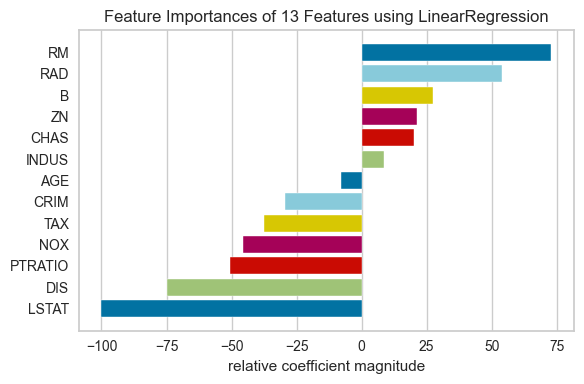

In [19]:
from yellowbrick.features import FeatureImportances

fig, ax = plt.subplots(figsize=(6, 4))  # Create a figure and axis with a specific size for the plot
fi_viz = FeatureImportances(            # Initialize the FeatureImportances visualizer
    lr2, labels=bos_X.columns           # Pass the trained model (lr2) and the feature names from the original DataFrame
)
fi_viz.fit(bos_sX, bos_y)               # Fit the visualizer using the standardized features and target values
fi_viz.poof();                          # Display the feature importance plot

*Feature importance. This indicates that RM (number of rooms) increases the price, age doesn’t really matter, and LSTAT (percent of low status in population) lowers the price.*

### SVMs
Support vector machines can perform regression as well.

In [22]:
from sklearn.svm import SVR 

svr = SVR()                          # Initialize the SVR model with default parameters
svr.fit(bos_sX_train, bos_sy_train)  # Fit the SVR model to the standardized training data (bos_sX_train) and target (bos_sy_train)

SVR()

In [23]:
r2_score_svr = svr.score(bos_sX_test, bos_sy_test)  # Calculate and return the R^2 score of the model on the standardized test data
print(f"Model R^2 Score on the standardized Test Data: {r2_score_svr:.3f}")     # Print the R^2 score on the standardized test data

Model R^2 Score on the standardized Test Data: 0.655


### K-Nearest Neighbor
The KNN model also supports regression by finding k neighbor targets to the sample for which you want to predict. For regression, this model averages the targets together to determine a prediction.

In [25]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor()          # Initialize the KNeighborsRegressor model with default parameters
knr.fit(bos_sX_train, bos_sy_train)  # Fit the KNeighborsRegressor model to the standardized training data and targets

KNeighborsRegressor()

In [26]:
r2_score_knr = knr.score(bos_sX_test, bos_sy_test)   # Calculate and return the R^2 score of the model on the standardized test data
print(f"Model R^2 Score on the standardized Test Data: {r2_score_knr:.3f}")     # Print the R^2 score on the standardized test data

Model R^2 Score on the standardized Test Data: 0.748


### Decision Tree
Decision trees support classification and regression. At each level of the tree, various splits on features are evaluated. The
split that will produce the lowest error (impurity) is chosen. The criterion parameter can be adjusted to determine the metric for impurity.

In [28]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)  # Initialize the DecisionTreeRegressor model, setting a random state for reproducibility
dtr.fit(bos_X_train, bos_y_train)             # Train the DecisionTreeRegressor on the training data (bos_X_train) and targets (bos_y_train)

DecisionTreeRegressor(random_state=42)

In [29]:
r2_score_tree = dtr.score(bos_X_test, bos_y_test)            # Calculate and return the R² score of the model on the test dataset
print(f"Model R^2 Score on the standardized Test Data: {r2_score_tree:.3f}")  # Print the R^2 score on the standardized test data

Model R^2 Score on the standardized Test Data: 0.844


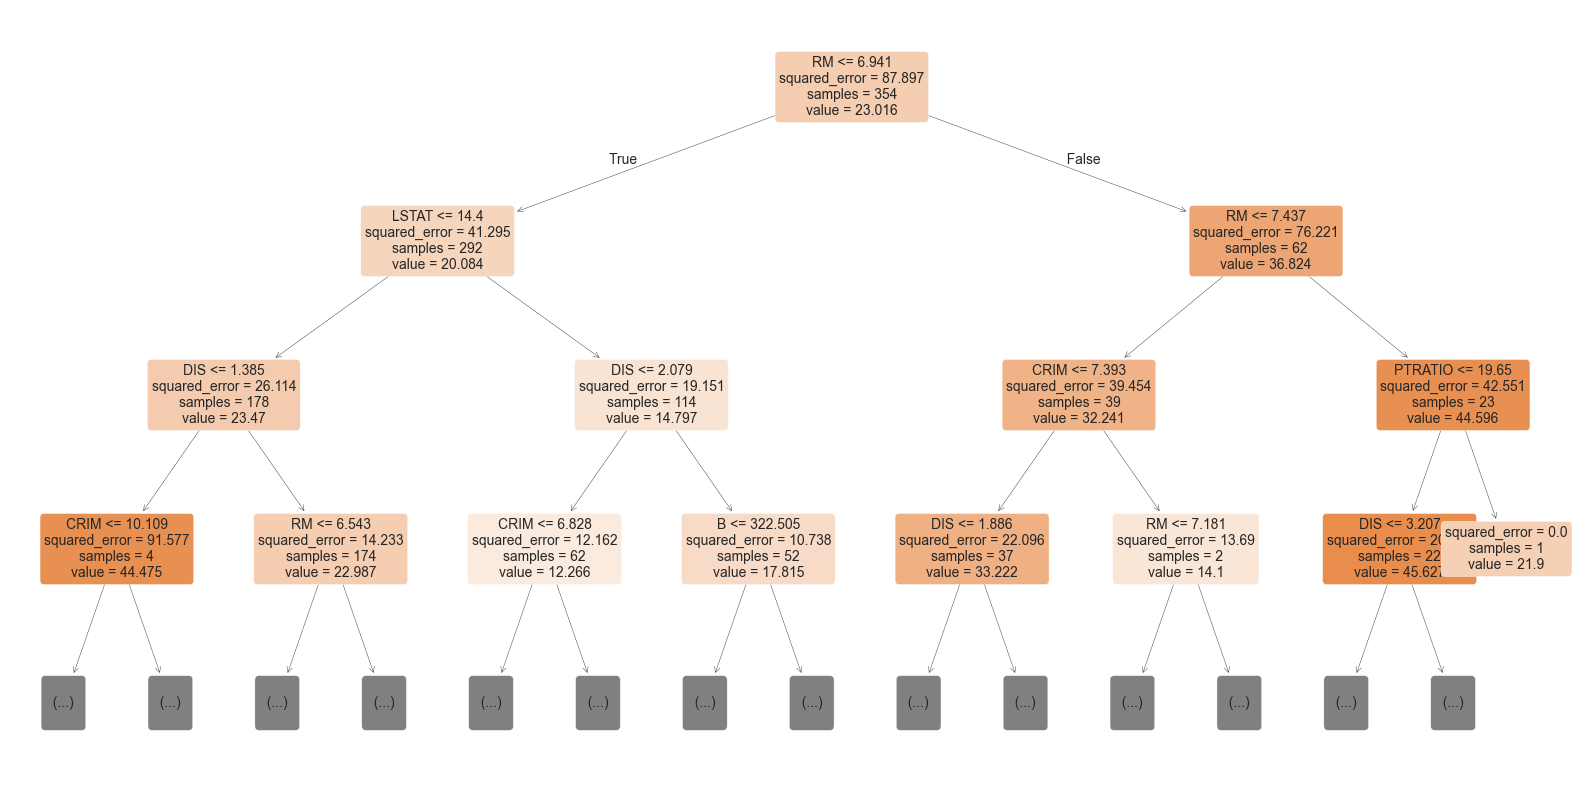

In [30]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set up the plot
plt.figure(figsize=(20, 10))  # Adjust figure size for readability

# Plot the decision tree with only the first 3 levels
plot_tree(
    dtr,                          # Decision tree model
    feature_names=bos_X.columns,  # Feature names
    filled=True,                  # Color the nodes by purity
    rounded=True,                 # Rounded corners for nodes
    fontsize=10,                  # Adjust font size for readability
    max_depth=3                   # Limit to first 3 levels
)

# Save the plot as an image file
#plt.savefig("decision_tree_first_3_levels.png", format="png")  # Save as PNG file
plt.show()

Feature and Threshold (e.g., `RM <= 6.941`): This is the feature and the threshold used for the split. In this case, the model splits on RM (average number of rooms per dwelling) at a threshold value of 6.941.

If `RM ≤ 6.941` (left side of the tree): The tree continues down the left path, where the samples have a lower average number of rooms. This subset of samples has:

    squared_error = 41.295
    samples = 292
    value = 20.084 (average target value for this subset).

If `RM > 6.941` (right side of the tree): The tree moves to the right, where the samples generally have a higher average number of rooms. This subset of samples has:

    squared_error = 76.221
    samples = 62
    value = 36.824 (average target value for this subset).

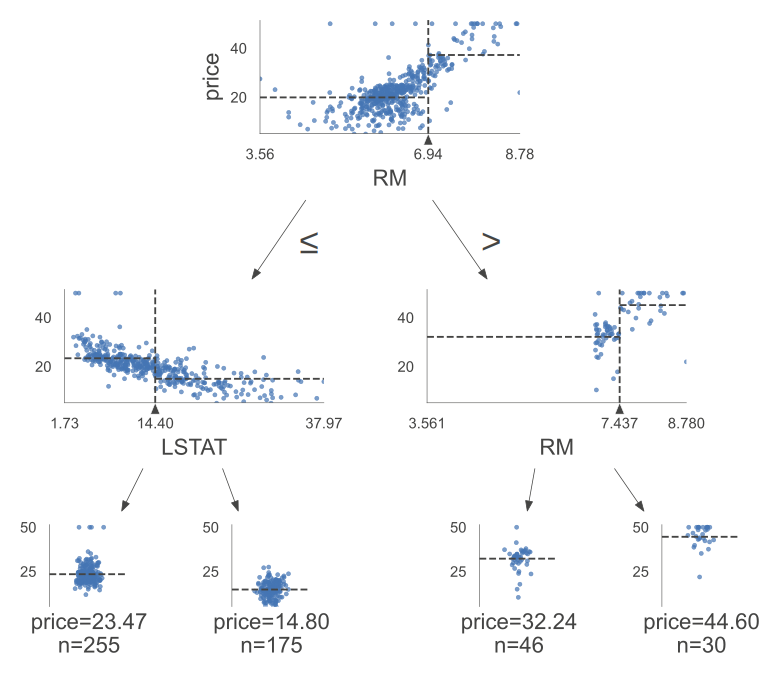

In [32]:
from dtreeviz import model

# Train a decision tree with a maximum depth of 2
dtr3 = DecisionTreeRegressor(max_depth=2)
dtr3.fit(bos_X_train, bos_y_train)

# Create the visualization model
viz_model = model(
    dtr3,                        # The trained decision tree model
    X_train=bos_X,               # The training feature data in DataFrame format
    y_train=bos_y,               # Target data
    feature_names=bos_X.columns, # Feature names
    target_name="price"          # Name of the target variable
)

# Display the decision tree
viz_model.view(scale=2.5)        # Increase scale to make the image larger

# Save the visualization as a PNG file
#viz.save("decision_tree_visualization.png")

#### Insights
    
    Root Node (Top Node) - Feature: RM (average number of rooms per dwelling): The split is based on the condition RM <= 6.94.
    
    For instances where RM <= 6.94, the model further splits based on LSTAT (percentage of lower status population).
    
    For instances where RM > 6.94, the model further splits based on RM again with a higher threshold (RM <= 7.437).

This decision tree structure highlights the hierarchical importance of `RM` and `LSTAT` in predicting prices, showing a clear relationship between room count, neighborhood status, and housing price levels.

In [35]:
# Iterate through the top 5 features with the highest importance in the decision tree model

for col, val in sorted(           # Sort and iterate through columns and feature importance values
    zip(                          # Zip together feature names and their importance scores
        bos_X.columns, dtr.feature_importances_  # Feature names and their corresponding importance in the model
    ),
    key=lambda x: x[1],           # Sort by feature importance value
    reverse=True,                 # Sort in descending order to get the most important features first
)[:5]:                            # Slice to get only the top 5 features
    print(f"{col:10}{val:10.3f}") # Print feature name and importance value, formatted to 3 decimal places

RM             0.576
LSTAT          0.190
DIS            0.110
CRIM           0.058
PTRATIO        0.025


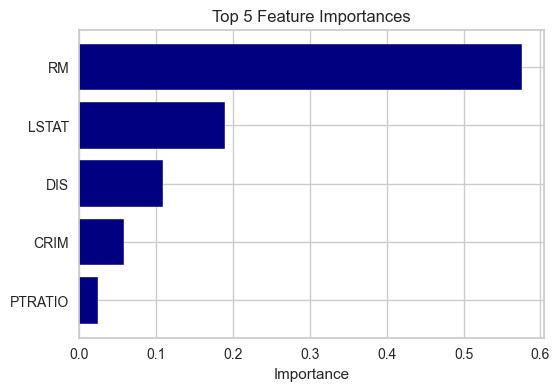

In [36]:
# Get feature importances and sort them in descending order
feature_importances = sorted(
    zip(bos_X.columns, dtr.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)[:5]  # Select the top 5 features

# Split feature names and their importance values for plotting
features, importances = zip(*feature_importances)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='navy')
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show();

### Random Forest
Decision trees are good because they are explainable, but they have a tendency to overfit. A random forest trades some of the
explainability for a model that tends to generalize better. This model can also be used for regression.

In [38]:
from sklearn.ensemble import RandomForestRegressor


# Initialize the random forest regressor model with a specific random state and number of trees
rfr = RandomForestRegressor(
    random_state=42,  # Set random state for reproducibility
    n_estimators=100  # Use 100 trees
)

# Train the random forest regressor model on the training dataset
rfr.fit(bos_X_train, bos_y_train)

RandomForestRegressor(random_state=42)

In [39]:
r2_score_rfr = rfr.score(bos_X_test, bos_y_test)           # Calculate and return the R^2 score of the model on the test dataset
print(f"Model R^2 Score on the standardized Test Data: {r2_score_rfr:.3f}")  # Print the R^2 score on the standardized test data

Model R^2 Score on the standardized Test Data: 0.871


In [40]:
# Iterate through the top 5 features with the highest importance in the Random Forest Regressor model

for col, val in sorted(           # Sort and iterate through columns and feature importance values
    zip(                          # Zip together feature names and their importance scores
        bos_X.columns, rfr.feature_importances_  # Feature names and their corresponding importance in the model
    ),
    key=lambda x: x[1],           # Sort by feature importance value
    reverse=True,                 # Sort in descending order to get the most important features first
)[:5]:                            # Slice to get only the top 5 features
    print(f"{col:10}{val:10.3f}") # Print feature name and importance value, formatted to 3 decimal places

RM             0.440
LSTAT          0.380
DIS            0.066
CRIM           0.032
PTRATIO        0.019


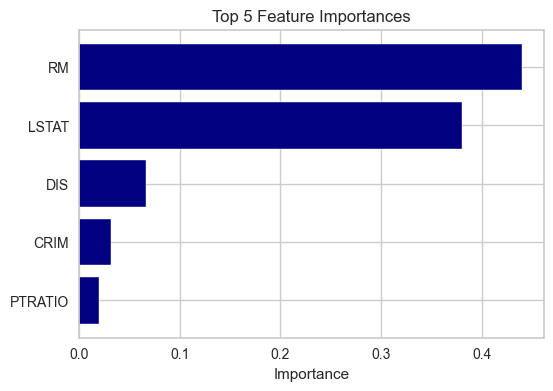

In [41]:
# Get feature importances and sort them in descending order
feature_importances = sorted(
    zip(bos_X.columns, rfr.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)[:5]  # Select the top 5 features

# Split feature names and their importance values for plotting
features, importances = zip(*feature_importances)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='navy')
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show();

### XGBoost Regression
The XGBoost library also supports regression. It builds a simple decision tree, then “boosts” it by adding subsequent trees.
Each tree tries to correct the residuals of the previous output. In practice, this works quite well on structured data.

In [43]:
import xgboost as xgb

# Initialize the XGBoost regressor with a specified random state for reproducibility
xgr = xgb.XGBRegressor(random_state=42)

# Train the XGBoost regressor model on the training dataset
xgr.fit(bos_X_train, bos_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [44]:
# Calculate and return the R^2 score of the model on the test dataset
xgr.score(bos_X_test, bos_y_test)

0.8729544676981909

In [45]:
# Use the trained model to predict the target value for the first instance in bos_X
xgr.predict(bos_X.iloc[[0]])

array([26.637667], dtype=float32)

In [46]:
# Loop through the top 5 features sorted by their importance as determined by the XGBoost model

for col, val in sorted(                          # Begin loop to iterate through sorted feature names and their importance values
    zip(                                         # Pair each feature name with its corresponding importance value
        bos_X.columns, xgr.feature_importances_  # Retrieve feature names and their importances from the trained model
    ),
    key=lambda x: x[1],                          # Sort the paired values by importance in descending order
    reverse=True,                                # Ensure sorting is in descending order for highest importance first
)[:5]:                                           # Limit to the top 5 most important features
    print(f"{col:10}{val:10.3f}")                # Print each feature's name and its importance value with 3 decimal places

LSTAT          0.403
RM             0.307
DIS            0.087
PTRATIO        0.068
TAX            0.029


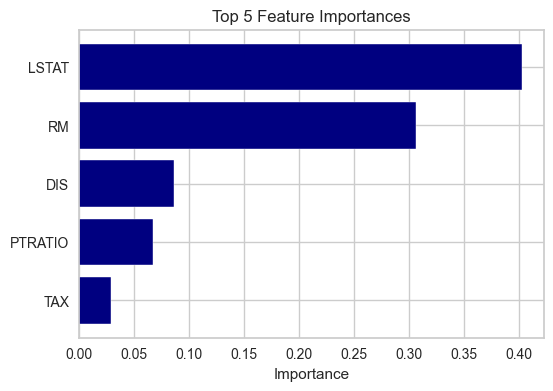

In [47]:
# Get feature importances and sort them in descending order
feature_importances = sorted(
    zip(bos_X.columns, xgr.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)[:5]  # Select the top 5 features

# Split feature names and their importance values for plotting
features, importances = zip(*feature_importances)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='navy')
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show();

*`LSTAT` with 0.403 means it contributes 40.3% of the total model's decision-making power based on gain.*

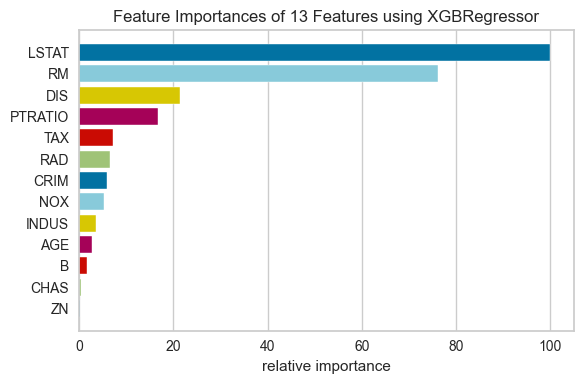

In [49]:
from yellowbrick.features import FeatureImportances

fig, ax = plt.subplots(figsize=(6, 4))                  # Create a figure and axis with specific dimensions
fi_viz = FeatureImportances(xgr, labels=bos_X.columns)  # Initialize FeatureImportances with XGBoost model and feature names
fi_viz.fit(bos_X_train, bos_y_train)                    # Fit the visualizer to the training data
fi_viz.show();                                          # Display the feature importance plot

#fig.savefig("mlpr_1406.png", dpi=300)

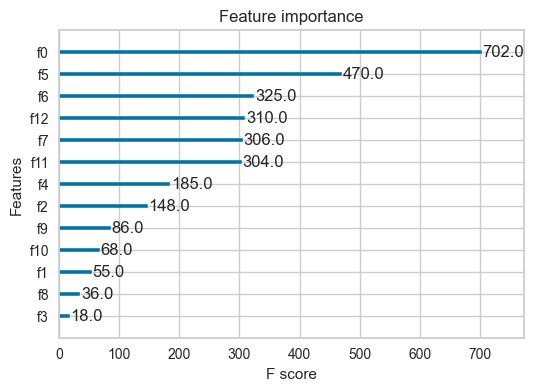

In [50]:
# Feature Importance: F-Score (how many times the feature was chosen to split)

fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgr, ax=ax);
#fig.savefig("mlpr_1405.png", dpi=300)

*If `f0` has an F score of 702, it means f0 was chosen 702 times to split nodes in the trees.*

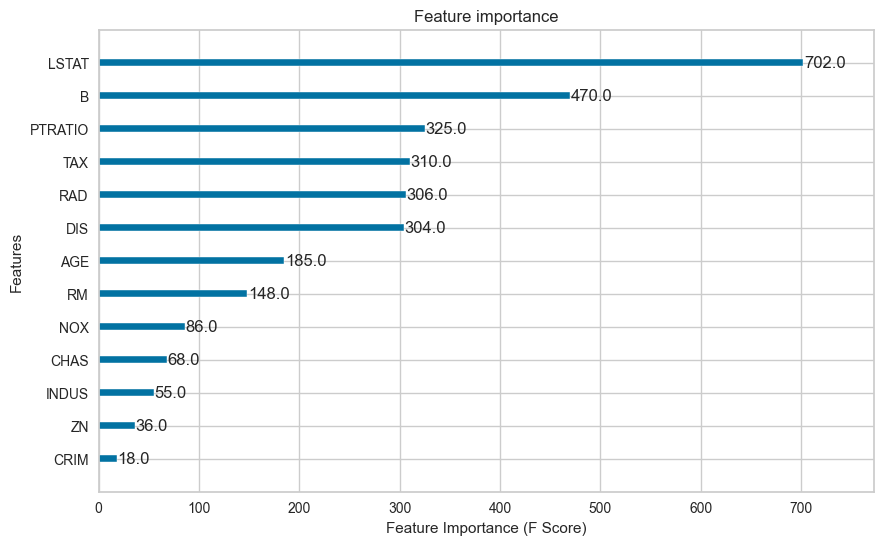

In [52]:
# Plot feature importance using the real feature names
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(
    xgr, 
    ax=ax, 
    importance_type='weight',              # You can also use 'gain' or 'cover' for other types of importance
    xlabel='Feature Importance (F Score)'  # Label for x-axis
)

# Rename the feature names
ax.set_yticklabels(bos_X.columns)  # Set y-axis labels to the real feature names

# Save the figure
#fig.savefig("feature_importance_real_names.png", dpi=300)
plt.show();

*`LSTAT` has an F score of 702, it means `LSTAT` was chosen 702 times to split nodes in the trees.*

In [54]:
booster = xgr.get_booster()   # Retrieve the trained booster (tree ensemble) object from the XGBoost model
print(booster.get_dump()[0])  # Print the first tree's structure in the model as a text-based dump

0:[f5<6.94299984] yes=1,no=2,missing=2
	1:[f12<14.4300003] yes=3,no=4,missing=4
		3:[f7<1.38610005] yes=7,no=8,missing=8
			7:[f0<8.49213028] yes=15,no=16,missing=16
				15:leaf=6.07144117
				16:leaf=0.732627034
			8:[f5<6.54899979] yes=17,no=18,missing=18
				17:[f12<7.78999996] yes=25,no=26,missing=26
					25:[f12<5.63999987] yes=35,no=36,missing=36
						35:leaf=0.787097394
						36:leaf=0.0659914389
					26:[f5<6.10099983] yes=37,no=38,missing=38
						37:leaf=-0.759166777
						38:leaf=-0.301650971
				18:[f12<7.01000023] yes=27,no=28,missing=28
					27:[f10<17.8999996] yes=39,no=40,missing=40
						39:leaf=2.06367588
						40:leaf=0.838728786
					28:[f7<3.4217] yes=41,no=42,missing=42
						41:leaf=1.1530751
						42:leaf=0.18386735
		4:[f7<2.07879996] yes=9,no=10,missing=10
			9:[f0<6.39311981] yes=19,no=20,missing=20
				19:[f6<88.5] yes=29,no=30,missing=30
					29:leaf=-0.242373005
					30:leaf=-2.37043929
				20:leaf=-3.59292293
			10:[f11<316.029999] yes=21,no=22,missing=2

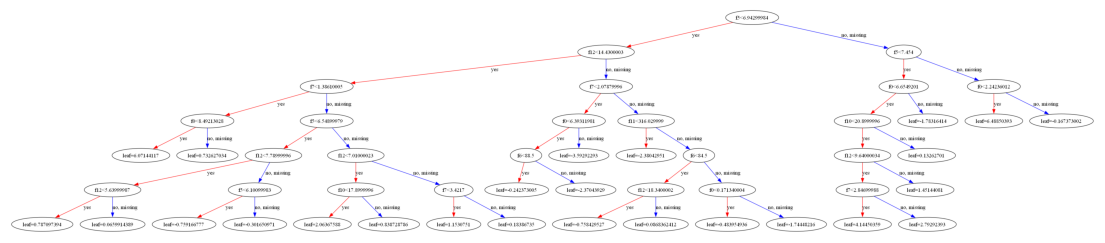

In [55]:
fig, ax = plt.subplots(figsize=(14, 12))       # Create a figure and axis with a specified size
xgb.plot_tree(xgr, ax=ax, num_trees=0);        # Plot the first tree in the XGBoost model
#fig.savefig("images/mlpr_1007.png", dpi=300)